In [14]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

TRAIN_DIR = 'D:/Dataset/train'
TEST_DIR = 'D:/Dataset/test1'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic')

In [15]:
def label_img(img):
    word_label = img.split('.')[-3]
    #conversion to one-hot array [cat,dog]
    #                           [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                           [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

In [16]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [17]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [19]:
#train_data = create_train_data()
# If you have already created the dataset:
train_data = np.load('train_data.npy')
print(train_data)
print(len(train_data))

[[array([[ 67,  67,  73, ..., 139, 136, 130],
       [ 66,  75,  73, ..., 137, 115, 136],
       [ 58,  62,  74, ..., 142, 130, 136],
       ...,
       [112, 109, 107, ...,  40,  68,  66],
       [115, 116, 105, ...,  71,  69,  71],
       [111, 112, 110, ...,  76,  62,  68]], dtype=uint8)
  array([1, 0])]
 [array([[53, 50, 49, ...,  4,  3,  3],
       [52, 51, 52, ...,  7,  4,  4],
       [54, 52, 51, ...,  4,  4,  4],
       ...,
       [67, 66, 59, ..., 67, 77, 48],
       [60, 56, 54, ..., 61, 83, 45],
       [54, 50, 45, ..., 57, 90, 42]], dtype=uint8)
  array([1, 0])]
 [array([[ 86, 103, 106, ..., 137, 137, 134],
       [ 87, 104, 108, ..., 137, 137, 136],
       [ 88, 105, 108, ..., 137, 137, 136],
       ...,
       [ 52,  51,  54, ...,  66,  66,  63],
       [ 63,  57,  58, ...,  68,  66,  64],
       [ 51,  53,  50, ...,  68,  67,  63]], dtype=uint8)
  array([1, 0])]
 ...
 [array([[119, 121, 121, ..., 118, 118, 118],
       [121, 122, 119, ..., 119, 119, 116],
       [121, 1

In [20]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [21]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [22]:
train = train_data[:-500]
test = train_data[-500:]

print(len(train))
print(len(test))

print(train.shape)
print(test.shape)

24500
500
(24500, 2)
(500, 2)


In [23]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [25]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 7659  | total loss: 0.21372 | time: 6.598s
| Adam | epoch: 020 | loss: 0.21372 - acc: 0.9058 -- iter: 24448/24500
Training Step: 7660  | total loss: 0.21045 | time: 7.617s
| Adam | epoch: 020 | loss: 0.21045 - acc: 0.9074 | val_loss: 0.65871 - val_acc: 0.7740 -- iter: 24500/24500
--


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:28<00:00, 441.47it/s]


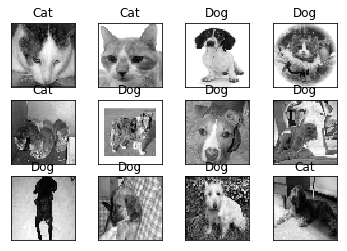

In [26]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()